In [1]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [2]:
# pip install transformers

In [3]:
# pip install -U scikit-learn scipy matplotlib

In [4]:
# pip install shapely

In [5]:
# pip install pandas

In [6]:
# pip install opencv-python

In [7]:
# pip install -U albumentations

In [8]:
# pip install scikit-image

In [9]:
# pip install datasets

In [10]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image 
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import pandas as pd
import cv2
import numpy as np
import matplotlib as plt
# import albumentations as aug

c:\Users\vravula\Downloads\Cracks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
WIDTH = 512
HEIGHT = 512

In [12]:
#one hot encode labels
def label_to_nparray(seg):
    channels = 19
    seg_0 = seg.shape[0]
    seg_1 = seg.shape[1]
    nparray = np.zeros([seg_0, seg_1, channels], dtype=np.uint8)
    for idx in range(0,channels):
        mask = seg == idx
        nparray[:,:,idx] = mask

        # if idx == 19:
        #     idx_ignore = 100
        #     mask = seg == idx_ignore
        #     nparray[idx,:,:] = mask

    return nparray

In [13]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        print("img dir: ", self.img_dir) #debug

        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        print("annotations dir: ", self.ann_dir) #debug
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        print("Imported Images ",len(self.images)) #debug
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)
        
        print("Imported Annotations ",len(self.annotations)) #debug

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        # print(self.img_dir) #debug
        # print(self.images[idx]) #debug
        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # print(self.ann_dir) #debug
        # print(self.annotations[idx]) #debug
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map = Image.fromarray(segmentation_map)

        # segmentation_map = Image.open()

        if self.transforms is not None:
            augmented_image = self.transforms(image)
            augmented_mask = self.transforms(segmentation_map)

            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented_image, augmented_mask, return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [14]:
import torchvision.transforms as transforms

# Define data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    # transforms.ColorJitter(brightness=.5, hue=.3)
])

In [15]:
# C:\Users\vravula\Downloads\Cracks\data\dacl10k_v2_devphase\resized\data\labels\validation
root_dir = 'C:/Users/vravula/Downloads/Cracks/data_megazord'

# feature_extractor = SegformerImageProcessor(align=False, reduce_zero_label=False)
feature_extractor = SegformerImageProcessor()

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

img dir:  C:/Users/vravula/Downloads/Cracks/data_megazord\images\train
annotations dir:  C:/Users/vravula/Downloads/Cracks/data_megazord\annotations\train
Imported Images  20805
Imported Annotations  20805
img dir:  C:/Users/vravula/Downloads/Cracks/data_megazord\images\validation
annotations dir:  C:/Users/vravula/Downloads/Cracks/data_megazord\annotations\validation
Imported Images  2925
Imported Annotations  2925


In [16]:
train_dataset

In [17]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 20805
Number of validation examples: 2925


In [18]:
encoded_inputs = train_dataset[0]

In [19]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [20]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [21]:
# cv2.imwrite("test_label.png",encoded_inputs["labels"].numpy())

In [22]:
np.nonzero(encoded_inputs["labels"])

tensor([[182, 221],
        [183, 215],
        [183, 216],
        ...,
        [356, 287],
        [356, 288],
        [357, 287]])

In [23]:
encoded_inputs["labels"].any()

tensor(True)

In [24]:
encoded_inputs["labels"].squeeze()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [25]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 0, 10])

In [26]:
mask = encoded_inputs["labels"].numpy()

In [27]:
import matplotlib.pyplot as plt

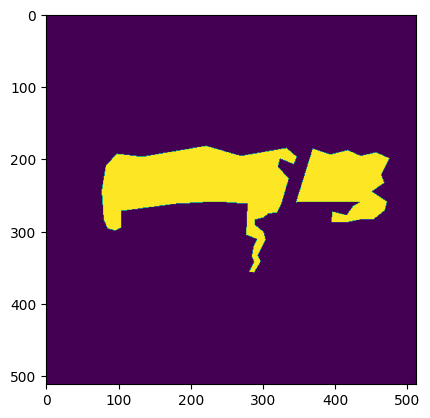

In [28]:
plt.imshow(mask)

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

In [30]:
batch = next(iter(train_dataloader))

In [31]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([8, 3, 512, 512])
labels torch.Size([8, 512, 512])


In [32]:
batch["labels"].shape

torch.Size([8, 512, 512])

In [33]:
# !git clone https://github.com/phiyodr/dacl10k-toolkit.git

In [34]:
%cd C:\Users\vravula\Downloads\Cracks\dacl10k-toolkit

C:\Users\vravula\Downloads\Cracks\dacl10k-toolkit


c:\Users\vravula\Downloads\Cracks\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [35]:
# from dacl10k.dacl10kdataset import Dacl10kDataset

# split = "validation" # "train", "testdev" (later also "testchallenge")
# path_to_data = "../data_megazord/a"
# dataset = Dacl10kDataset(split, path_to_data, resize_mask=(512, 512), resize_img=(512, 512), normalize_img=True)

# img, mask = dataset[10]
# img.shape, mask.shape

# target_list = dataset.TARGET_LIST
# target_list
# #> (torch.Size([3, 512, 512]), torch.Size([19, 512, 512]))

In [36]:
target_list = ['Crack',
 'ACrack',
 'Wetspot',
 'Efflorescence',
 'Rust',
 'Rockpocket',
 'Hollowareas',
 'Cavity',
 'Spalling',
 'Graffiti',
 'Weathering',
 'Restformwork',
 'ExposedRebars',
 'Bearing',
 'EJoint',
 'Drainage',
 'PEquipment',
 'JTape',
 'WConccor']

In [37]:
from dacl10k import utils

id2label = dict(zip(range(1, len(utils.TARGET_LIST) + 1),utils.TARGET_LIST))
id2label[0] = "unlabelled"
id2label

{1: 'Crack',
 2: 'ACrack',
 3: 'Wetspot',
 4: 'Efflorescence',
 5: 'Rust',
 6: 'Rockpocket',
 7: 'Hollowareas',
 8: 'Cavity',
 9: 'Spalling',
 10: 'Graffiti',
 11: 'Weathering',
 12: 'Restformwork',
 13: 'ExposedRebars',
 14: 'Bearing',
 15: 'EJoint',
 16: 'Drainage',
 17: 'PEquipment',
 18: 'JTape',
 19: 'WConccor',
 0: 'unlabelled'}

In [38]:
label2id = {v: k for k, v in id2label.items()}

In [39]:
len(id2label)

20

## Training

In [40]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", 
                                                         ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), 
                                                         id2label=id2label, 
                                                         label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [42]:
# from torchsummary import summary
# summary(model, (3, 512,512))

In [43]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


In [44]:
!nvidia-smi

Wed Dec  6 12:55:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  | 00000000:01:00.0  On |                  Off |
| 30%   42C    P2              56W / 450W |   2934MiB / 24564MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [45]:
# for idx, batch in enumerate(next(iter(train_dataloader))):
#     print(batch)
#     # get the inputs;
#     pixel_values = batch["pixel_values"].to(device)
#     print(pixel_values)
#     labels = batch["labels"].to(device)
#     print(labels)


In [46]:
from tqdm import tqdm
from datasets import load_metric
metric = load_metric("mean_iou")

C:\Users\vravula\AppData\Local\Temp\ipykernel_2276\1103646631.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")


In [47]:
best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # print(batch['pixel_values'].shape)
        # print(batch['labels'].squeeze().unique())
        
        # get the inputs;
        pixel_values = batch['pixel_values'].to(device)
        labels = batch["labels"].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        
        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                # # note that the metric expects predictions + labels as numpy arrays
                # metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

                # # let's print loss and metrics every 100 batches
                # if idx % 100 == 0:
                #     metrics = metric._compute(
                #         references = labels.cpu(),
                #         predictions = predicted.cpu(),
                #         num_labels=len(id2label), 
                #         ignore_index=255,
                #         reduce_labels=False, # we've already reduced the labels before)
                #     )

                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    # Calculate average training and validation metrics
    avg_train_accuracy = sum(accuracies) / len(accuracies)
    avg_train_loss = sum(losses) / len(losses)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    avg_val_loss = sum(val_losses) / len(val_losses)

    print(f"Train Pixel-wise accuracy: {avg_train_accuracy}\
         Train Loss: {avg_train_loss}\
         Val Pixel-wise accuracy: {avg_val_accuracy}\
         Val Loss: {avg_val_loss}")

    # Check if the current model has the best validation accuracy
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        best_epoch = epoch

        # Save the current best model
        torch.save(model, f"C:/Users/vravula/Downloads/Cracks/segformer_checkpoints/best_model_epoch_{epoch}.pt")

print(f"Best model achieved at epoch {best_epoch} with validation accuracy: {best_val_accuracy}")

Epoch: 1


100%|██████████| 2601/2601 [35:53<00:00,  1.21it/s, Batch=2600, Pixel-wise accuracy=0.758, Loss=0.826]


Train Pixel-wise accuracy: 0.758387089435617         Train Loss: 0.8263831330819205         Val Pixel-wise accuracy: 0.7422011344159236         Val Loss: 0.8113183124713559
Epoch: 2


100%|██████████| 2601/2601 [35:02<00:00,  1.24it/s, Batch=2600, Pixel-wise accuracy=0.832, Loss=0.522]


Train Pixel-wise accuracy: 0.8322478743527129         Train Loss: 0.5215625040596927         Val Pixel-wise accuracy: 0.6599329500250477         Val Loss: 1.0062710669278447
Epoch: 3


100%|██████████| 2601/2601 [35:07<00:00,  1.23it/s, Batch=2600, Pixel-wise accuracy=0.877, Loss=0.376]


Train Pixel-wise accuracy: 0.87702280192685         Train Loss: 0.3761573561117402         Val Pixel-wise accuracy: 0.6032302757429946         Val Loss: 1.1691145026455811
Epoch: 4


100%|██████████| 2601/2601 [1:01:11<00:00,  1.41s/it, Batch=2600, Pixel-wise accuracy=0.904, Loss=0.29] 


Train Pixel-wise accuracy: 0.904046184051408         Train Loss: 0.290230885949394         Val Pixel-wise accuracy: 0.7327296835477234         Val Loss: 0.9419796792942969
Epoch: 5


100%|██████████| 2601/2601 [2:20:27<00:00,  3.24s/it, Batch=2600, Pixel-wise accuracy=0.918, Loss=0.244]  


Train Pixel-wise accuracy: 0.9179160027172143         Train Loss: 0.2440228313307884         Val Pixel-wise accuracy: 0.7339042204976733         Val Loss: 0.9815369809015853
Epoch: 6


  0%|          | 5/2601 [00:20<2:55:26,  4.05s/it, Batch=5, Pixel-wise accuracy=0.886, Loss=0.32] 


KeyboardInterrupt: 

In [48]:
torch.save(model, f"C:/Users/vravula/Downloads/Cracks/segformer_checkpoints/b5_model_epoch_{epoch}.pt")